### 실전 데이터분석반 최종 과제 - 크몽

안녕하세요. **DS School** X **크몽**입니다.

실전 데이터분석반의 최종 과제를 전달합니다. 이번 과제는 프리랜서 마켓 플랫폼 크몽의 데이터를 활용하여, 특정 사용자의 액티비티를 살펴보거나 전체 통계량을 살펴보는 일을 할 것입니다.

<Img src = 'https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/11Yx/image/jNo1MfbPhIsud4DhAFh5fej9nQA.jpg' width=240>

크몽에서는 사용자가 서비스에 방문하면서 일어나는 모든 행동을 로그로 기록하고 있습니다. 로그 데이터는 서비스 자체를 상징하기에, 로그 데이터를 분석할 수 있다면 서비스를 다양한 관점에서 살펴보는 것이 가능합니다. 로그 데이터를 활용해서 할 수 있는 주요 업무는 다음과 같습니다.

  * 회사의 주요 핵심 지표 분석. 가령 전환율(Conversion Rate), 이탈률(Bounce rate) 등
  * 이를 더 세분화하여, 각 페이지별 전환율과 이탈률을 분석.
  * 사용자의 인구통계학정보(나이, 성별 등), 지역(서울, 부산 등), 사용 기기(아이폰, 갤럭시) 마다의 핵심 지표 분석.
  * 특정 상황에서 서비스상의 버그로 인해 사용자가 이탈하는 현상 감지.

<small>(참고 자료: <a href="http://woowabros.github.io/woowabros/2017/07/30/logdata.html">우아한형제들 기술블로그. 로그 데이터로 유저 이해하기</a>)</small>

그러므로 이번 최종 과제에서는 크몽의 로그 데이터를 활용하여, 사용자의 액티비티를 실시간으로 확인하거나, 서비스상에 문제(버그 등)가 없는지를 데이터 분석을 통해 알아볼 것입니다.

과제를 푸는데 주어진 시간은 없습니다. 과제를 받은 뒤, 시간에 구애받지 않고 천천히 문제를 풀어주세요. 이번 과제는 빠르게 푸는 것 보다 정확하게 푸는 것이 더 중요하다고 강조하고 싶습니다. 과제를 정확하게 풀었다는 기준은 다음과 같습니다.

  * 예시와 동일한 결과가 출력되는 코드를 작성해야 합니다. 결과가 예시와 다를 경우 무언가 코드에 오류가 있을 가능성이 있습니다.
  * 코드가 깔끔하게 정리되어 있고, 모듈화(=함수)가 잘 되어있으며, 코멘트가 자세하게 적혀 있어서 비 개발 직군(ex: 운영팀, 마케팅팀)이 코드와 코멘트를 보고 직접 수정할 수 있어야 합니다.
  * 장기적인 관점에서 확장 가능한 코드를 작성해야 합니다. 가령 사용자의 액티비티를 확인하는 코드를 작성할 때, 1) 로그 데이터에 새로운 컬럼이 추가되거나 2) 홈페이지나 어플리케이션에 새로운 기능이 생겼을 때 이를 자동으로 반영할 수 있어야 합니다.
  
과제를 모두 푼 분들은 datascience@dsschool.co.kr 에 1) 과제를 푼 쥬피터 노트북(.ipynb 파일)과, 2) 본인의 이력서를 첨부파일로 제출해주세요. 제출 결과를 확인한 뒤 크몽 담당 팀에게 전달하도록 하겠습니다. (단, 면접용 과제이기 때문에 이전 수업처럼 솔루션을 제공해드릴 수 없는 점 양해 부탁드립니다)


In [1]:
import glob
import pandas as pd
import matplotlib
from IPython.display import set_matplotlib_formats

from tqdm import tqdm_notebook

import pickle


import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:


# 화면에 출력할 최대 컬럼 개수를 50개로 늘려줍니다.
pd.options.display.max_columns = 50

# Mac OS를 이용하고 있기 떄문에 AppleGothic을 설정했습니다.
# 윈도우의 경우 다른 폰트를 사용해주셔야 합니다. 나눔폰트가 있는 경우 'NanumGothic' 없는 경우에는 'Malgun Gothic'을 사용해주세요.
#matplotlib.rc('font', family='AppleGothic')
matplotlib.rc('font', family="Malgun Gothic")

# 별도로, 폰트를 바꿀 경우 마이너스가 표시되지 않는 경우도 있는데 이를 막아주는 코드입니다.
matplotlib.rc('axes', unicode_minus=False)

# retina 옵션을 통해 해상도를 올립니다.
set_matplotlib_formats('retina')

### Load Dataset


먼저 크몽의 로그 데이터를 하나씩 가져오겠습니다. 먼저 가져올 데이터는 크몽 어플리케이션의 이벤트와 전환을 나타내는 ````kmong-conversion-v2-.csv``` 입니다. 컬럼 정보는 다음과 같습니다.

* ```eventcategory```: 앱의 이벤트에 대한 카테고리입니다. 크게 다음의 종류가 있습니다.
  - ```install```: 앱설치
  - ```launch```: 앱실행 
  - ```deeplinkLaunch```: 딥링크 통한 앱실행
  - ```goal```: 앱 내에서의 활동 여부
  - ```exit```: 앱 종료
  - ```foreground```, background```: 앱을 foreground, background로 전환
  - ```launchlnSession```: Session의 시작.
* ```isfirstactivity```: 해당 이벤트가 해당 유저에 한하여 첫 번째인지 혹은 두 번째 이상인지를 알려주는 값입니다. 
  - boolean 형식으로, 해당 이벤트가 해당 유저에 한하여 첫 번째 이벤트이면 True, 아니면 False를 갖습니다.
* ```apppackagename```: 앱의 패키지의 고유한 이름입니다. 안드로이드의 경우 applicationId을, iOS의 경우 Bundle ID를 가져오게 됩니다.
* ```appversion```: kmong 어플리케이션의 버전입니다.
* ```devicetype```: 사용자가 kmong app을 실행하고 있는 기기의 제품명입니다.
* ```devicemanufacturer```: 사용자가 kmong app을 실행하고 있는 기기의 제조회사입니다. 
* ```osversion```: 사용자가 kmong app을 실행하고 있는 기기의 os 버전입니다.
* ```canonicaldeviceuuid```: 사용자가 kmong app을 실행하고 있는 기기의 고유 식별자입니다. (사용자를 구분하는 식별자로 이용할 수 있습니다)
* ```sourcetype```: 해당 로그를 만든 고객이 유입된 경로입니다. 유료 광고 채널, 바이럴 채널, 앱 마켓 등으로 구분합니다.
* ```channel```: sourcetype과 동일하지만 조금 더 세분화되어 있습니다.
  - unattributed, WEB, google-play, m_naver, google, (not set), google.adwords, m_naverpowercontents, pc_naver, apple.searchads, facebook, m_daum
* ```params_campaign```: 마케터가 입력한 캠페인 파라미터 중 캠페인명입니다. 
* ```params_medium```: 마케터가 입력한 캠페인 파라미터 중 매체입니다.
* ```params_term```: 마케터가 입력한 캠페인 파라미터 중 키워드입니다.
* ```inappeventcategory```: 인앱이벤트 식별자값으로 인앱이벤트를 지칭하는 3개의 값(category > action > label) 중 가장 상위에 속하는 구분값입니다.
  - ```eventcategory```가 goal인 경우에만 제공됩니다.
  - 차후에 읽어올 funnel 데이터셋과 연결할 수 있습니다.
  - ex) seller_selling_history.view, gig_detail.view
* ```inappeventlabel```: categoryid와 동일합니다.
  - 차후에 읽어올 category 데이터셋과 연결할 수 있습니다.
  - 인앱이벤트를 지칭하는 3개의 값(category > action > label) 중 마지막에 속하는 구분값입니다.
* ```eventdatetime```: 모바일 클라이언트 상에서의 실제 이벤트 발생시간입니다. ISO 8601 표준에 따라서 제공됩니다. 
* ```isfirstgoalactivity```: goal 이벤트의 경우, 해당 Goal Label, Description, Key, Category를 가진 이벤트가 해당 유저에 한하여 첫 번째인지 혹은 두 번째 이상 인지를 알려주는 boolean 값입니다. 예를 들어 동일한 유저로부터 두 번 이상의 같은 Goal 이벤트가 발생한 경우(e.g. 동일한 물건 재구매 등) 이 값은 false가 됩니다.

* ```event_rank```: 데이터를 정렬하는데 필요한 컬럼입니다. log엔 기록되지 않으며, DS_School에서 제공하는 전처리된 컬럼입니다.

In [3]:
# kmong-conversion- 관련 csv파일 경로를 전부 가져옵니다.
file_list = glob.glob('D:/2. python/2. DS_School/DS/interview/kmong/data/raw_data/kmong-conversion-*.csv')

# 리스트의 메소드 중 하나인 .sort()를 이용하여 시간 순서대로 리스트를 정렬합니다.
file_list.sort()

# 상위 5개를 출력합니다.
file_list[:5]

['D:/2. python/2. DS_School/DS/interview/kmong/data/raw_data\\kmong-conversion-v2-20180928000000-20180928005959.csv',
 'D:/2. python/2. DS_School/DS/interview/kmong/data/raw_data\\kmong-conversion-v2-20180928010000-20180928015959.csv',
 'D:/2. python/2. DS_School/DS/interview/kmong/data/raw_data\\kmong-conversion-v2-20180928020000-20180928025959.csv',
 'D:/2. python/2. DS_School/DS/interview/kmong/data/raw_data\\kmong-conversion-v2-20180928030000-20180928035959.csv',
 'D:/2. python/2. DS_School/DS/interview/kmong/data/raw_data\\kmong-conversion-v2-20180928040000-20180928045959.csv']

In [4]:
# read_csv로 모든 kmong-conversion 데이터를 읽어온 뒤
# 이를 판다스의 concatenate로 하나로 합칩니다.
log = pd.concat([pd.read_csv(csv, low_memory=False) for csv in tqdm_notebook(file_list)])

# log 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(log.shape)

# head()로 log 데이터의 상위 5개를 띄웁니다.
log.head(50)


(434244, 19)


,eventcategory,isfirstactivity,apppackagename,appversion,devicetype,devicemanufacturer,osversion,canonicaldeviceuuid,sourcetype,channel,params_campaign,params_medium,params_term,inappeventcategory,inappeventlabel,eventdatetime,rowuuid,isfirstgoalactivity,event_rank
0,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,unattributed,unattributed,NaN,NaN,NaN,home.view,NaN,2018-09-28T00:00:00+09:00,fd2a188c-bc9b-4702-9c47-b546b2614817,False,True
1,goal,False,com.kmong.kmong,3.3.5,SM-N935S,samsung,Android7.0,8a871e50-0717-4aed-9bad-04ac3c3793be,unattributed,unattributed,NaN,NaN,NaN,gig_detail.view,41201.0,2018-09-28T00:00:00+09:00,e62dccef-dd70-4415-8a33-c8324ddaed38,False,True
2,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS12.0,A9E5778A-8F3D-4597-9718-74BF953A9F64,unattributed,unattributed,NaN,NaN,NaN,inbox_detail.view,NaN,2018-09-28T00:00:00+09:00,14eb3197-db83-493a-b7be-83582960c40b,False,True
3,foreground,NaN,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,168761CB-CB67-4592-867D-52780D651297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-28T00:00:01+09:00,f9bb91af-248b-44dc-9f5c-1c00b37ea97b,NaN,True
4,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,ACABB7C0-4C76-413A-B314-E5D6DA0D0E5D,viral,WEB,NaN,NaN,NaN,buyer_order_track.view,NaN,2018-09-28T00:00:02+09:00,236e9946-7801-4898-b609-06c8ab1139dc,False,True
5,goal,False,com.kmong.kmong,3.3.5,SM-G955N,samsung,Android8.0.0,6d1ea29b-5d5d-4c33-b2cf-7c68b41ce638,unattributed,unattributed,NaN,NaN,NaN,home.view,NaN,2018-09-28T00:00:02+09:00,db8ce65f-3707-4c1b-8361-51bcb9d4ecd9,False,True
6,goal,False,com.kmong.kmong,3.3.5,SM-N935S,samsung,Android7.0,8a871e50-0717-4aed-9bad-04ac3c3793be,unattributed,unattributed,NaN,NaN,NaN,gig_detail.view,41201.0,2018-09-28T00:00:02+09:00,a6d462c3-d4a3-4a2c-8942-88f2cae0012e,False,True
7,launch,False,com.kmong.kmong,3.3.5,SM-G930S,samsung,Android8.0.0,a3b89a23-034a-4f4c-8414-adda3dc711cd,unattributed,unattributed,NaN,NaN,NaN,NaN,NaN,2018-09-28T00:00:02+09:00,be1137d1-bf1d-4e42-8ad2-ae0d98bf3c03,False,False
8,background,NaN,com.kmong.kmong,3.3.5,SM-G960N,samsung,Android8.0.0,75bd8d01-c903-446b-bed5-fdba742bde2c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-28T00:00:03+09:00,d75ee65f-a82f-40a6-b123-93afd0a703fb,NaN,True
9,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,168761CB-CB67-4592-867D-52780D651297,unattributed,unattributed,NaN,NaN,NaN,buyer_order_history.view,NaN,2018-09-28T00:00:03+09:00,e646eb49-3288-4379-8994-daaf6de1fec3,False,True


**Funnel_ID_app.p**

그 다음 가져올 데이터셋은 퍼널(Funnel) 정보입니다.

퍼널은은 한국어로 해석하면 깔대기로, 사용자가 서비스 접속 후 상품을 구매하기까지의 경로 구조를 의미합니다. 결제를 하기 위해서는 무조건 상품 설명을 통해서 방문해야하고, 상품 설명을 보기 위해서는 해당 상품을 찾을 수 있는 카테고리탭을 통해서만 방문할 수 있기 때문에 가장 마지막 단계 페이지의 방문자가 가장 적을 수 밖에 없습니다. 이러한 구조가 깔대기같다 하여 퍼널이라 불립니다.

퍼널을 이용해 전환과 이탈률을 측정함으로써 집중 개선 대상 페이지를 발견할 수 있으며 개선된 페이지의 성과까지 간단히 추적해 나갈 수 있습니다. 크몽 또한 앱에 다양한 퍼널이 구성되어 있고, 그 정보가 'Funnel_ID_app.p'에 저장되어 있습니다.

In [5]:
# pickle을 활용해 퍼널 데이터를 읽어옵니다.
# 그리고 이 데이터를 funnel이라는 이름의 변수에 저장합니다.
funnel = pickle.load(open('D:/2. python/2. DS_School/DS/interview/kmong/data/kmong_rawdata_app_reference_tables/Funnel_ID_app.p','rb'))

# funnel 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(funnel.shape)

# funnel 데이터 전체를 출력합니다.
funnel

(53, 6)


,Lv2,viewid,viewid desc,Lv1,funnel name,funnel desc
0,1100,home,홈 (탭),11,home,홈
1,1210,category_list,카테고리 목록 (탭),12,category,카테고리
2,1200,category_gig,카테고리-상품목록,12,category,카테고리
3,1300,search,검색,13,search,검색
4,1301,search_gig,검색-상품목록,13,search,검색
5,1302,search_seller,검색-전문가,13,search,검색
6,1400,gig_detail,상품상세,14,gig,상품
7,1401,gig_detail_option,상품상세-상품선택,14,gig,상품
8,1420,profile,전문가프로필,14,gig,상품
9,1520,login_sns,간편로그인,15,login,로그인


마찬가지로 사용자가 어떤 상품탭에 들어갔는지에 대한 상품 분류 정보를 가지고 있는 categories.p 데이터도 pickle을 통해 읽어오겠습니다.

In [6]:
categories = pickle.load(open('D:/2. python/2. DS_School/DS/interview/kmong/data/kmong_rawdata_app_reference_tables/categories.p','rb'))

print(categories.shape)
categories

(245, 9)


,depth,categoryid,categoryname,cat1_id,cat2_id,cat3_id,cat1,cat2,cat3
0,1,1,디자인,1,NaN,NaN,디자인,NaN,NaN
1,1,2,마케팅,2,NaN,NaN,마케팅,NaN,NaN
2,1,3,번역·통역,3,NaN,NaN,번역·통역,NaN,NaN
3,1,4,문서작성,4,NaN,NaN,문서작성,NaN,NaN
4,1,6,IT·프로그래밍,6,NaN,NaN,IT·프로그래밍,NaN,NaN
...,...,...,...,...,...,...,...,...,...
240,3,72501,모델,7,725.0,72501.0,콘텐츠 제작,엔터테이너,모델
241,3,72502,MC,7,725.0,72502.0,콘텐츠 제작,엔터테이너,MC
242,3,72503,배우,7,725.0,72503.0,콘텐츠 제작,엔터테이너,배우
243,3,72504,공연,7,725.0,72504.0,콘텐츠 제작,엔터테이너,공연


### 1. 로그를 사용자별로 정렬한 뒤 살펴볼 수 있도록 정리해주세요.

로그데이터를 정리했으면 이를 정렬 및 분리를 하고 싶습니다. 기준은 다음과 같습니다.

  * 사용자 아이디(```userid```)마다 그룹핑이 되어있어야 합니다.
  * 그룹핑이 된 사용자를 기준으로, 최신 로그가 위로 올라와야 합니다.
  
또한 정리한 로그 데이터를 활용해 다음의 기능을 하는 함수를 구현했으면 좋겠습니다.

  * 특정 사용자 아이디(```userid```) 또는, 특정 사용자 아이디를 리스트로 여러 개 넣으면, 해당 사용자들의 로그 데이터만 별도록 색인할 수 있어야 합니다.
  * 특정 컬럼명을 리스트로 넣으면 해당 컬럼만 별도로 색인할 수 있어야 합니다.
  * 특정 ```viewid```를 리스트로 넣으면 그 ```viewid```에 해당하는 로그 데이터만 별도로 색인할 수 있어야 합니다.
  
최종적으로 다음의 결과가 나와야 합니다.

<table border="1" class="dataframe">
   <thead>
      <tr style="text-align: right;">
         <th></th>
         <th></th>
         <th>eventdatetime</th>
         <th>devicemanufacturer</th>
         <th>devicetype</th>
         <th>ostype</th>
         <th>osversion</th>
         <th>appversion</th>
         <th>eventcategory</th>
         <th>viewid</th>
         <th>viewaction</th>
         <th>funnel desc</th>
         <th>viewid desc</th>
         <th>categoryname</th>
         <th>category1</th>
         <th>category2</th>
         <th>category3</th>
         <th>sourcetype</th>
         <th>channel</th>
         <th>params_campaign</th>
         <th>params_medium</th>
         <th>params_term</th>
         <th>isfirstactivity</th>
         <th>isfirstgoalactivity</th>
      </tr>
      <tr>
         <th>userid</th>
         <th>rowuuid</th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
      </tr>
   </thead>
   <tbody>
      <tr>
         <th>00000000-0000-0000-0000-000000000000</th>
         <th>2461124f-cd69-4a4d-8c38-3a51dc3087e2</th>
         <td>2018-09-29 07:32:23</td>
         <td>Apple</td>
         <td>iPhone</td>
         <td>iOS</td>
         <td>11.4.1</td>
         <td>4.0.4</td>
         <td>install</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>False</td>
         <td>False</td>
      </tr>
      <tr>
         <th rowspan="4" valign="top">001B9A43-5F55-4145-84B5-6495DF1EAF80</th>
         <th>9e8a9758-b454-4f32-a905-112cd04e615b</th>
         <td>2018-09-29 11:07:35</td>
         <td>Apple</td>
         <td>iPhone</td>
         <td>iOS</td>
         <td>11.4.1</td>
         <td>4.0.4</td>
         <td>background</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>ea568a15-b66a-4618-97bf-ad9c9a8e40c9</th>
         <td>2018-09-29 11:07:34</td>
         <td>Apple</td>
         <td>iPhone</td>
         <td>iOS</td>
         <td>11.4.1</td>
         <td>4.0.4</td>
         <td>launch</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>False</td>
         <td>False</td>
      </tr>
      <tr>
         <th>d276e79c-fc5f-4fc6-acea-c62ff38e7225</th>
         <td>2018-09-29 02:56:41</td>
         <td>Apple</td>
         <td>iPhone</td>
         <td>iOS</td>
         <td>11.4.1</td>
         <td>4.0.4</td>
         <td>background</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>db1ab8b6-2782-4158-a95c-f64cf8219b60</th>
         <td>2018-09-29 02:56:21</td>
         <td>Apple</td>
         <td>iPhone</td>
         <td>iOS</td>
         <td>11.4.1</td>
         <td>4.0.4</td>
         <td>goal</td>
         <td>gig_detail</td>
         <td>view</td>
         <td>상품</td>
         <td>상품상세</td>
         <td>로고디자인</td>
         <td>디자인</td>
         <td>로고디자인</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>True</td>
         <td>False</td>
      </tr>
   </tbody>
</table>

만일 특정 사용자, 가령 ```user_id```가 **fff40190-d751-425a-9813-2284072e47f5**인 사용자의 로그 데이터만 색인하면 다음의 결과가 나와야 합니다.

<table border="1" class="dataframe">
   <thead>
      <tr style="text-align: right;">
         <th></th>
         <th>eventdatetime</th>
         <th>devicemanufacturer</th>
         <th>devicetype</th>
         <th>ostype</th>
         <th>osversion</th>
         <th>appversion</th>
         <th>eventcategory</th>
         <th>viewid</th>
         <th>viewaction</th>
         <th>funnel desc</th>
         <th>viewid desc</th>
         <th>categoryname</th>
         <th>category1</th>
         <th>category2</th>
         <th>category3</th>
         <th>sourcetype</th>
         <th>channel</th>
         <th>params_campaign</th>
         <th>params_medium</th>
         <th>params_term</th>
         <th>isfirstactivity</th>
         <th>isfirstgoalactivity</th>
      </tr>
      <tr>
         <th>rowuuid</th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
      </tr>
   </thead>
   <tbody>
      <tr>
         <th>12dc5a10-2713-4a96-9693-3e29ca1a0f5c</th>
         <td>2018-09-28 00:03:19</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>background</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>f55223e0-52f5-41c2-8f0b-41c562baa3fc</th>
         <td>2018-09-28 00:03:16</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>False</td>
         <td>False</td>
      </tr>
      <tr>
         <th>457da225-eaf2-4ffe-94e0-d3ffb7b93490</th>
         <td>2018-09-28 00:02:41</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>False</td>
         <td>False</td>
      </tr>
      <tr>
         <th>d1da5023-8ef1-46ae-bd79-ab9208854c73</th>
         <td>2018-09-28 00:02:41</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>launchInSession</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>20b8dfa9-4ac9-4b53-87d4-86db737fd7ef</th>
         <td>2018-09-27 23:51:25</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>background</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>a9d0ac01-b715-46f2-b92d-8570dfbc2cca</th>
         <td>2018-09-27 23:51:08</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>False</td>
         <td>False</td>
      </tr>
      <tr>
         <th>af9381ed-25ca-4ba2-9a99-9a06f4c9bc26</th>
         <td>2018-09-27 23:50:22</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>launch</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>False</td>
         <td>False</td>
      </tr>
      <tr>
         <th>a773ad20-fb9c-4c6d-96fd-1861dec0cea8</th>
         <td>2018-09-27 23:50:22</td>
         <td>Samsung</td>
         <td>SM-G950N</td>
         <td>Android</td>
         <td>8.0.0</td>
         <td>3.3.3</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>unattributed</td>
         <td>unattributed</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>False</td>
         <td>False</td>
      </tr>
   </tbody>
</table>

또한 가령 ```user_id```가 **fff40190-d751-425a-9813-2284072e47f5**인 사용자의 로그 데이터 중에서, ```eventdatetime```, ```eventcategory```, ```viewid```, ```viewaction```, ```funnel desc```, ```viewid desc``` 컬럼만 출력하길 원한다면 다음의 결과가 나와야 합니다.

<table border="1" class="dataframe" style="float: left;">
   <thead>
      <tr style="text-align: right;">
         <th></th>
         <th>eventdatetime</th>
         <th>eventcategory</th>
         <th>viewid</th>
         <th>viewaction</th>
         <th>funnel desc</th>
         <th>viewid desc</th>
      </tr>
      <tr>
         <th>rowuuid</th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
         <th></th>
      </tr>
   </thead>
   <tbody>
      <tr>
         <th>12dc5a10-2713-4a96-9693-3e29ca1a0f5c</th>
         <td>2018-09-28 00:03:19</td>
         <td>background</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>f55223e0-52f5-41c2-8f0b-41c562baa3fc</th>
         <td>2018-09-28 00:03:16</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
      </tr>
      <tr>
         <th>457da225-eaf2-4ffe-94e0-d3ffb7b93490</th>
         <td>2018-09-28 00:02:41</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
      </tr>
      <tr>
         <th>d1da5023-8ef1-46ae-bd79-ab9208854c73</th>
         <td>2018-09-28 00:02:41</td>
         <td>launchInSession</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>20b8dfa9-4ac9-4b53-87d4-86db737fd7ef</th>
         <td>2018-09-27 23:51:25</td>
         <td>background</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>a9d0ac01-b715-46f2-b92d-8570dfbc2cca</th>
         <td>2018-09-27 23:51:08</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
      </tr>
      <tr>
         <th>af9381ed-25ca-4ba2-9a99-9a06f4c9bc26</th>
         <td>2018-09-27 23:50:22</td>
         <td>launch</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
         <td>NaN</td>
      </tr>
      <tr>
         <th>a773ad20-fb9c-4c6d-96fd-1861dec0cea8</th>
         <td>2018-09-27 23:50:22</td>
         <td>goal</td>
         <td>inbox_detail</td>
         <td>view</td>
         <td>메시지</td>
         <td>메시지목록-상세</td>
      </tr>
   </tbody>
</table>

마지막으로 ```user_id```가 **fff40190-d751-425a-9813-2284072e47f5**인 사용자의 로그 데이터 중에서, ```viewid```가 "home", "inbox_detail", "inbox", "gig_detail", "thankyou" 인 로그 데이터만 출력하길 원한다면 다음의 결과가 나와야 합니다.

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>eventdatetime</th>      <th>devicemanufacturer</th>      <th>devicetype</th>      <th>ostype</th>      <th>osversion</th>      <th>appversion</th>      <th>eventcategory</th>      <th>viewid</th>      <th>viewaction</th>      <th>funnel desc</th>      <th>viewid desc</th>      <th>categoryname</th>      <th>category1</th>      <th>category2</th>      <th>category3</th>      <th>sourcetype</th>      <th>channel</th>      <th>params_campaign</th>      <th>params_medium</th>      <th>params_term</th>      <th>isfirstactivity</th>      <th>isfirstgoalactivity</th>    </tr>    <tr>      <th>rowuuid</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>f55223e0-52f5-41c2-8f0b-41c562baa3fc</th>      <td>2018-09-28 00:03:16</td>      <td>Samsung</td>      <td>SM-G950N</td>      <td>Android</td>      <td>8.0.0</td>      <td>3.3.3</td>      <td>goal</td>      <td>inbox_detail</td>      <td>view</td>      <td>메시지</td>      <td>메시지목록-상세</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>unattributed</td>      <td>unattributed</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>False</td>      <td>False</td>    </tr>    <tr>      <th>457da225-eaf2-4ffe-94e0-d3ffb7b93490</th>      <td>2018-09-28 00:02:41</td>      <td>Samsung</td>      <td>SM-G950N</td>      <td>Android</td>      <td>8.0.0</td>      <td>3.3.3</td>      <td>goal</td>      <td>inbox_detail</td>      <td>view</td>      <td>메시지</td>      <td>메시지목록-상세</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>unattributed</td>      <td>unattributed</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>False</td>      <td>False</td>    </tr>    <tr>      <th>a9d0ac01-b715-46f2-b92d-8570dfbc2cca</th>      <td>2018-09-27 23:51:08</td>      <td>Samsung</td>      <td>SM-G950N</td>      <td>Android</td>      <td>8.0.0</td>      <td>3.3.3</td>      <td>goal</td>      <td>inbox_detail</td>      <td>view</td>      <td>메시지</td>      <td>메시지목록-상세</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>unattributed</td>      <td>unattributed</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>False</td>      <td>False</td>    </tr>    <tr>      <th>a773ad20-fb9c-4c6d-96fd-1861dec0cea8</th>      <td>2018-09-27 23:50:22</td>      <td>Samsung</td>      <td>SM-G950N</td>      <td>Android</td>      <td>8.0.0</td>      <td>3.3.3</td>      <td>goal</td>      <td>inbox_detail</td>      <td>view</td>      <td>메시지</td>      <td>메시지목록-상세</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>unattributed</td>      <td>unattributed</td>      <td>NaN</td>      <td>NaN</td>      <td>NaN</td>      <td>False</td>      <td>False</td>    </tr>  </tbody></table>

다음의 기능을 구현한 ```find_log```라는 함수를 구현해주세요.

In [7]:
# 추출하고 싶은 정보 입력 하세요
##분석할 대상(dataframe):
def what_df(df):
    main=df.copy()
    return main

###############################################################################
###############################################################################

# merge 함수
def df_merge(data):
    #원본 복사
    data['eventdatetime']=pd.to_datetime(data['eventdatetime'])

    # view, viewaction 생성
    data['viewid']=data['inappeventcategory'].str.split('.').str[0]
    data['viewaction']=data['inappeventcategory'].str.split('.').str[1]
    
    ## merge log_g+pannel
    data=pd.merge(data,funnel,on="viewid",how="left")
    
    ## merge log_g+category
    data=pd.merge(data,categories,left_on="inappeventlabel",right_on="categoryid",
                   how="left")
    
    data=col_edit(data)
    
    return data
###############################################################################
## ostype 쪼개기
def parmodel(data):
    if data.find('iOS')>-1:
        model="iOS"
        return model
    elif data.find('Android')>-1:
        model="Android"
        return model


def parver(data):
    if data.find('iOS')>-1:
        ver=data[3:len(data)]
        return ver
    elif data.find('Android')>-1:
        ver=data[7:len(data)]
        return ver

###############################################################################
def make_date_col(df_f):
    df_f['day']=df_f['eventdatetime'].dt.day
    df_f['hour']=df_f['eventdatetime'].dt.hour
    df_f['minute']=df_f['eventdatetime'].dt.minute
    
    return df_f

###############################################################################
# 수정
def col_edit(df):
    ## ostype 수정
    df['ostype']=df['osversion'].apply(parmodel)
    df['osversion']=df['osversion'].apply(parver)

    ## 열이름 수정
    df=df.rename(columns=
             {'cat1':'category1',
              'cat2':'category2',
              'cat3':'category3',
              'canonicaldeviceuuid':'userid'
              })
    df=make_date_col(df)
    df['eventdatetime']=df['eventdatetime'].apply(f_todatetime)
    
    return df


###############################################################################
## LOCAL TIME을 UTC로 바꾸는 함수  KST = +09:00
def f_todatetime(data):
    UTC_OFFSET = 9
    result_utc_datetime=data-datetime.timedelta(hours=UTC_OFFSET )
    result = result_utc_datetime.strftime("%Y-%m-%d %H:%M:%S")
    
    return result

###############################################################################
def fine_log(user_id = None, columns = None, viewid = None,maindf=None):
    # merge
    main=df_merge(maindf)
    
    # 인덱스설정
    main=main.set_index("rowuuid")
    
    # 날짜 편집 localtime -> UTC
    
    
       
    # 입력안한 자료에 대해 정보 추가해주기
    if(user_id==None):
        user_id = list(main['userid'].unique())     
    if(columns==None):
        columns = final_col
    if(viewid==None):
        viewid=list(main['viewid'].unique())
    
    #userid에 해당하는 행 골라내기    
    main=main[main['userid'].isin(user_id)]
    #viewid에 해당하는 행 골라내기
    main=main[main['viewid'].isin(viewid)]
    
    #나중에 grouping할 userid뽑아두기
    userid=pd.DataFrame({'userid':main['userid']})
    #최종적으로 필요한 열 골라내기
    df=main.loc[:,columns]
    
    
    
    #userid와 최종 골라진 데이터 프레임 concat
    con_df=pd.concat([userid, df],axis=1)
    
    #userid별 날짜별로 sorting
    finalcol=['userid','rowuuid']+columns
    reset_df=con_df.reset_index(drop=False)
    final_df=reset_df[finalcol]
    
    sort_df=final_df.sort_values(by=['userid','eventdatetime'],ascending=[True,False])
    sort_df=sort_df.reset_index(drop=True)
    sort_df['eventdatetime']=pd.to_datetime(sort_df['eventdatetime'])
    
    return sort_df
###############################################################################
## 결과 출력
# 추출하고 싶은 col 작성
final_col=['eventdatetime','devicemanufacturer','devicetype','ostype','osversion',
'appversion','eventcategory','viewid','viewaction','funnel desc','viewid desc',	
'categoryname','category1','category2','category3','sourcetype','channel',
'params_campaign','params_medium','params_term','isfirstactivity',
'isfirstgoalactivity']

##원하는 정보 입력
maindf=what_df(log)
userid=None
columns=None
viewid=None

df=fine_log(userid,columns,viewid,maindf)
df

,userid,rowuuid,eventdatetime,devicemanufacturer,devicetype,ostype,osversion,appversion,eventcategory,viewid,viewaction,funnel desc,viewid desc,categoryname,category1,category2,category3,sourcetype,channel,params_campaign,params_medium,params_term,isfirstactivity,isfirstgoalactivity
0,00000000-0000-0000-0000-000000000000,2461124f-cd69-4a4d-8c38-3a51dc3087e2,2018-09-29 07:32:23,Apple,iPhone,iOS,11.4.1,4.0.4,install,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unattributed,unattributed,NaN,NaN,NaN,False,False
1,001B9A43-5F55-4145-84B5-6495DF1EAF80,9e8a9758-b454-4f32-a905-112cd04e615b,2018-09-29 11:07:35,Apple,iPhone,iOS,11.4.1,4.0.4,background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001B9A43-5F55-4145-84B5-6495DF1EAF80,ea568a15-b66a-4618-97bf-ad9c9a8e40c9,2018-09-29 11:07:34,Apple,iPhone,iOS,11.4.1,4.0.4,launch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unattributed,unattributed,NaN,NaN,NaN,False,False
3,001B9A43-5F55-4145-84B5-6495DF1EAF80,d276e79c-fc5f-4fc6-acea-c62ff38e7225,2018-09-29 02:56:41,Apple,iPhone,iOS,11.4.1,4.0.4,background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001B9A43-5F55-4145-84B5-6495DF1EAF80,db1ab8b6-2782-4158-a95c-f64cf8219b60,2018-09-29 02:56:21,Apple,iPhone,iOS,11.4.1,4.0.4,goal,gig_detail,view,상품,상품상세,로고디자인,디자인,로고디자인,NaN,unattributed,unattributed,NaN,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434239,ffffffff-c6bb-8616-cd10-2dbd151c76e2,2d93369e-d40d-4b24-bc9c-4f569b9fd4d5,2018-09-29 04:53:15,samsung,SHV-E250S,Android,4.1.2,3.3.5,background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434240,ffffffff-c6bb-8616-cd10-2dbd151c76e2,fd4b85e1-b0f6-401a-946a-377572823490,2018-09-29 04:53:14,samsung,SHV-E250S,Android,4.1.2,3.3.5,exit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434241,ffffffff-c6bb-8616-cd10-2dbd151c76e2,742eaabd-fefb-4765-a3bb-b27c5a7efc8c,2018-09-29 04:53:14,samsung,SHV-E250S,Android,4.1.2,3.3.5,foreground,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434242,ffffffff-c6bb-8616-cd10-2dbd151c76e2,3be0b187-14d7-4d01-92cc-535f153fc168,2018-09-29 04:53:08,samsung,SHV-E250S,Android,4.1.2,3.3.5,background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. 최근 48시간의 페이지뷰의 변화량을 출력해주세요.

정리한 로그 데이터를 바탕으로, 로그가 기록된 2018년 09월 28일부터 29일까지의 48시간동안 발생한 페이지뷰의 변화량을 출력하고 싶습니다. 사용자가 서비스를 한 번 이용할 때 마다 페이지뷰가 한 번 올라갔다고 가정합니다. (즉, 전체 데이터의 개수인 434,244개를 최근 48시간동안의 페이지뷰라고 가정하겠습니다) 가령 다음의 그림이 나와야 합니다.

In [8]:
# 아래에서 예시 보이겠습니다

이 그림에 추가로, 다음의 조건에 해당하는 데이터만 별도로 페이지뷰를 출력할 수 있도록 할 것입니다.

  1. OS(```ostype```)별 페이지뷰, 가령 iOS와 Android마다의 페이지뷰의 변화량을 알 수 있어야 합니다.
  1. OS버전(```osversion```)별 페이지뷰, 가령 특정 버전(ex: 11.4.1)마다의 페이지뷰의 변화량을 알 수 있어야 합니다.
  1. 디바이스(```devicetype```)별 페이지뷰, 가령 특정 디바이스(ex: iPhone)마다의 페이지뷰의 변화량을 알 수 있어야 합니다.
  1. 어플리케이션 버전(```appversion```)별 페이지뷰, 가령 특정 버전(ex: 4.0.4)마다의 페이지뷰의 변화량을 알 수 있어야 합니다.
  
이 시각화를 출력했을 때, 특정 조건에서 페이지뷰가 급감한다면 해당 OS나 디바이스에서 구동하는 어플리케이션에 버그가 있을 가능성이 있습니다. 이 경우 운영팀/개발팀에게 빠르게 이 사실을 전달하여 디버깅을 해야 할 것입니다.

가령 전체 페이지뷰 대비 아이폰(iPhone)에서 동작하는 어플리케이션의 페이지뷰의 변화량은 다음과 같습니다.

In [9]:
# 아래에서 예시 보이겠습니다

또한 전체 페이지뷰 대비 특정 버전(ex: 4.0.4)에서 동작하는 페이지뷰의 변화량은 다음과 같습니다.

In [10]:
# 아래에서 예시 보이겠습니다

다음의 기능을 구현하는 ```plot_pageview```라는 함수를 구현해주세요.

In [11]:
# plot_pageview라는 함수를 정의합니다. 함수에는 여러 옵션이 들어가는데,
# ostype, osversion, devicetype, appversion 모두 하나의 문자열 또는 리스트를 넣을 수 있습니다.
# 이 경우 인자로 넣은 정보에 해당하는 조건만 별도로 시각화를 합니다.
# 이 인자의 기본 값은 None입니다. 이 경우 해당 조건으로 별도 시각화를 하지 않습니다.


# 몇 분 단위(u_minute)에 들어가있는지
def minute_arr(m_arr,w_minute):
    
    def minute_n(data):
        value=data//w_minute
        return value
    
    result=m_arr.apply(minute_n)
    
    return result


def make_plot_ingredient(du,df_f,u_minute):
    df_f=make_date_col(df_f)
    
    # 몇 분 단위(u_minute)에 들어가있는지
    df_f['g']=minute_arr(df_f['minute'],u_minute)
    # 결과 (시간별 뷰활동 합)
    count_minute=df_f.groupby(['day','hour','g'])['c'].sum()
    # x축 개수를 정해준다.
    x_time=list(range(0,du*60-1,u_minute))
    
    return [x_time,count_minute]



# plot_pageview에 입력한 인자가 어느 col인지
def T_F(data):
    u_ostype=main_df['ostype'].unique()
    u_osversion=main_df['osversion'].unique()
    u_device=main_df['devicemanufacturer'].unique()
    u_appversion=main_df['appversion'].unique()
    
    
    if(np.isin(data,u_ostype)==True):
        return 'ostype'
    elif(np.isin(data,u_osversion)==True):
        return 'osversion'
    elif(np.isin(data,u_device)==True):
        return 'devicemanufacturer'
    elif(np.isin(data,u_appversion)==True):
        return 'appversion'
        
#########            #############           ############           ######
def plot_pageview(du, df_f_f, u_minute, ostype = None, osversion = None, devicetype = None, appversion = None):
    df_f=df_f_f.copy()
    df_f['c']=1
    #받은 인자 정리
    want_list=[ostype,osversion,devicetype,appversion] #인자가 늘어나면 추가해주자.
    want_list=list(filter(None, want_list))  # None제거
    want_list=[element for array in want_list for element in array]  # 2중리스트 풀어주기
    
    #색 설정
    palette = sns.color_palette("Set3", 10) 
    
    plt.figure(figsize=[15,4])
    #일단 전체는 그기
    plot_ingr=make_plot_ingredient(du,df_f,u_minute)
    plt.plot(plot_ingr[0], plot_ingr[1],'r-',
                label="Total",color='red')   # Total 그림은 빨강색 지정
    
    # col이 None이 아닐때  그리기
    if want_list!=[]:
        for i in range(0,len(want_list)):
            df_f['c']=1
            want=T_F(want_list[i])
            idx=df_f[df_f[want]!=want_list[i]].index
            df_f.loc[idx,'c']=0
            plot_ingr=make_plot_ingredient(du,df_f,u_minute)
            plt.plot(plot_ingr[0], plot_ingr[1],'r-',
                label=want_list[i], color=palette[i])
                
    plt.xlabel("minute")
    plt.ylabel("count")
    plt.legend(loc="upper right")
    result = plt.show()
    return result

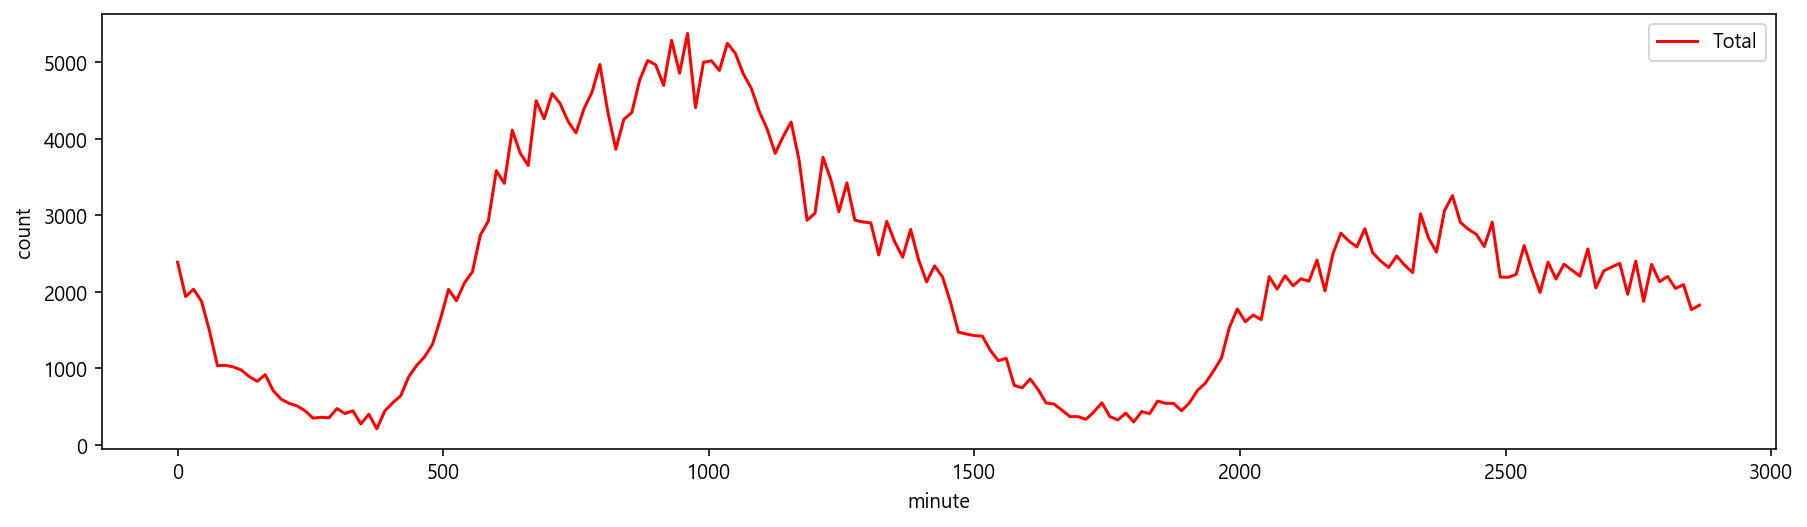

In [12]:
# 함수 사용
## 필요한 변수 입력
duration_H=48   ### 총 48시간이므로 48 입력
main_df=df      ### 데이터 입력
unit_minute=15  ### 60의 약수를 입력하세요 1,2,3,4,5,6,10,12,15,20,30,60  검색 시간 단위(주기)가 됩니다.->현재는 15분마다.

## Total
want_ostype=None
want_osversion=None
want_device=None
want_appversion=None

plot_pageview(duration_H,main_df,unit_minute,want_ostype,want_osversion,want_device,want_appversion)




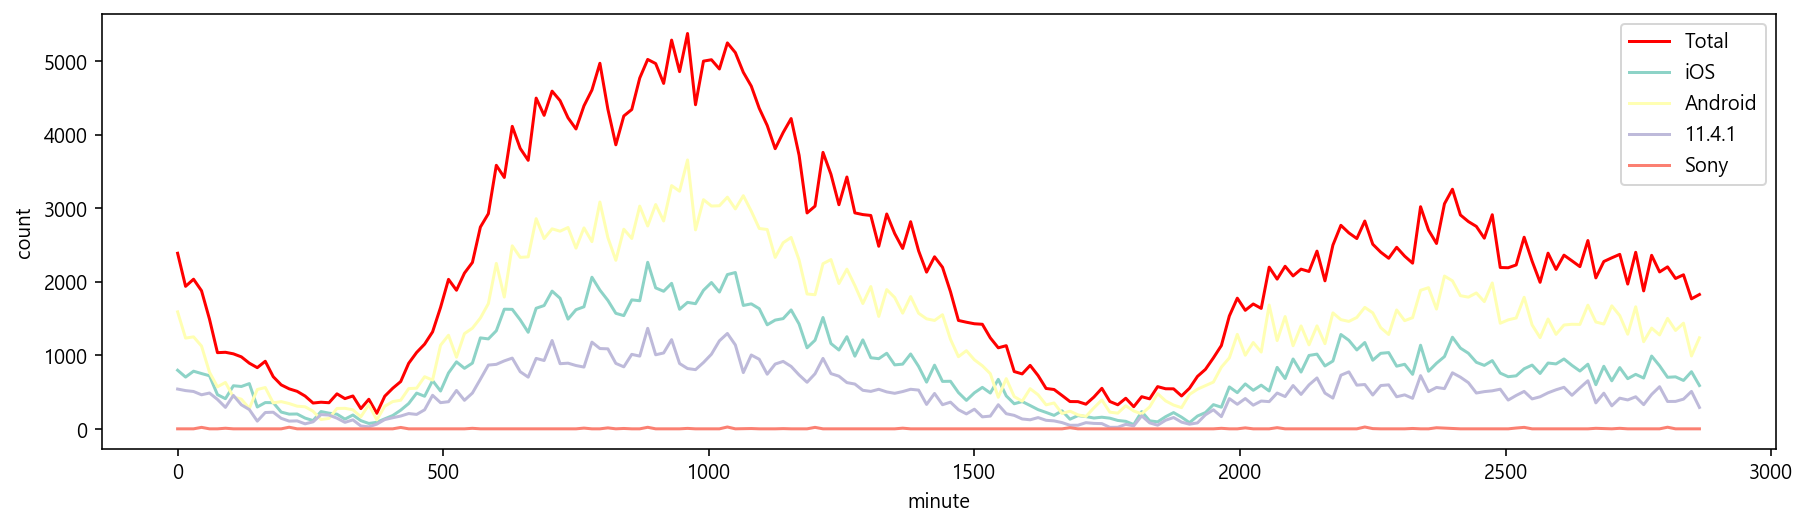

In [13]:
# 현 코드는 palette를 10개로 지정했기 때문에 원소의 수는 10개 이하인게 색 구분이 가능하다.
want_ostype=['iOS','Android']
want_osversion=['11.4.1']
want_device=['Sony']
want_appversion=None

plot_pageview(duration_H,main_df,unit_minute,want_ostype,want_osversion,want_device,want_appversion)


### 3. 자유 주제 - 데이터를 활용하여 자유롭게 시각화를 해주세요.

마지막 문제는 자유 주제입니다. 특정한 형식에 구애받지 않고 자유롭게 데이터 분석과 시각화를 통해 데이터에서 인사이트를 추출해주세요.

크몽의 데이터에는 아직 우리가 분석하지 않은 미지의 요소들이 있습니다. 몇 가지 예시를 적어보자면 다음과 같습니다.

  * 시간별 이탈률 분석(bounce rate), 내지는 특정 페이지나 디바이스별 이탈률을 분석할 수도 있습니다.
  * 퍼널 분석(Funnel analysis), 사용자가 서비스에 방문해서 목표를 달성할 때 까지의 모든 과정을 시각화하고 분석할 수도 있습니다. ([참고](https://www.slideshare.net/LeeGwan/ss-42159541))
  * 목표(ex: 상품 구매)를 달성하는 사용자와 달성하지 않는 사용자의 차이를 분석할 수 있습니다.
  
주어진 내용을 바탕으로 자유롭게 분석 및 시각화를 한 뒤 제출하세요. 문제를 푸는 지원자의 분석 스킬, 그리고 상상력과 창의력을 최대한 활용하기를 기대합니다.

In [15]:
###############################################################################
################################## 자유주제 ####################################
###############################################################################

# 주제 : 처음 앱 설치한 고객을 대상으로 분석을 해보자
## 1.처음 앱 설치한 고객을 대상으로 가입을 완료 한 고객  who_first_install_signup(free_df)
### 1-1 1.에 이어 이들이 크몽에 처음 들어오게 된 경로는?
## 2. 1결과에 이어 구매까지 걸린 시간
## 3. 2결과와 연결하여 어떤 상품을 구매했는지.
## 4. 3결과와 연결하여 들어온 경로


In [16]:

####### 앱설치 한 고객들을 대상으로

# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ #
###############################함수 모음########################################
def to_str(data):
        conv= str(data)
        return conv
###############       ################       ###############      #############
#install을 처음한 고객 전체 자료
def install_first(df):
    result=df[(df['eventcategory']=='install') & 
                        (df['isfirstactivity']==True)] # userid의 중복제거
    return result

###############       ################       ###############      #############
## 앱 처음설치한 사람중 가입한 사람 id 추출   
def who_first_install_signup(df):
    
    install_first_user= install_first(df)['userid']     
    
    ### 해당 id에 대한 전체 데이터
    new_df=df[df['userid'].isin(install_first_user)]
    
    ## id별 signup 갯수 파악하기(signup을 여러번 들어갈 수 있기 때문에. 단, signup.click은 없었다는걸 미리 파악함) sum((free_df['viewid']=='signup') & (free_df['viewaction']=='click'))
    signup_new=new_df[(new_df['viewid']=='signup')]
    
    
    ## True가 1이다. 가입으로 가정 count+1
    ## True가 1이고 False가 1개 이상이다. 가입으로 가정 count+1
    ## True가 없이 False만 있다. 가입x (기기변경한 사람임. 처음 앱 설치대상이지만 기기 변경 전에 가입했던 사람일 수 있기 때문에)
    test=pd.DataFrame({'userid':signup_new['userid'],
                       'T_F':signup_new['isfirstactivity'].apply(to_str),
                       'c':1
                       })
    
    test_unique=test.drop_duplicates()
    
    find_newuser=test_unique.set_index(['userid','T_F']).unstack('T_F')
    
    valueF = list(zip(*find_newuser.values))[0]
    valueT = list(zip(*find_newuser.values))[1]
    
    
    #index의 복잡성으로 새로운 DF 생성
    find_newuser_df=pd.DataFrame({'userid':list(find_newuser.index),
                               'T':valueT,
                               'F':valueF
            })
    
    find_newuser_df=find_newuser_df[find_newuser_df['T']!=0]
    find_newuser_df=find_newuser_df.fillna(0)
    return find_newuser_df
    



###############       ################       ###############      #############

# 경로에 따른 가입 확률
def new_signup(df):
    
    install_first_user=install_first(df)
    
    # 설치 처음한 고객 정보
    install_count=install_first_user.groupby(['sourcetype','channel'])['userid'].count()
    
    # 처음 가입한 고객 정보
    signup_id=who_first_install_signup(free_df)
    info_signup=install_first_user[install_first_user['userid'].isin(signup_id['userid'])]
    
    # 들어온 경로별로 파악
    ## sourcetype
    signup_count=info_signup.groupby(['sourcetype','channel'])['userid'].count()

    # install+signup
    ## groupby결과물은 D.F.으로 만들어도 이중index와, 값을 가져오는데에 불편함이 있기 때문에 새로운 D.F. 생성
    signup_con_df=pd.concat([install_count,signup_count],axis=1) 
    idx0=list(list(zip(*signup_con_df.index))[0])
    idx1=list(list(zip(*signup_con_df.index))[1])
    
    
    value0 = list(list(zip(*signup_con_df.values))[0])
    value1 = list(list(zip(*signup_con_df.values))[1])
    
    # ## 온전한 D.F. 생성 -> 플랏 그리기에 용이함
    signup_df=pd.DataFrame({"idx0" : idx0,
                 "idx1" : idx1,
                 "total" : value0,
                 "signup" : value1})
    signup_df=signup_df.fillna(0)    
        
    # 비율구하기
    signup_df['percent']=signup_df.iloc[:,3]/signup_df.iloc[:,2]*100
    
    
    plt.figure(figsize=[18,4])
    sns.barplot(x='idx1',y='percent',data=signup_df)
    plt.show()

    return signup_df

###############################################################################
# 처음 가입한 고객 전체 정보
def all_first_signup(df):
    result=df[df['userid'].isin(who_first_install_signup(df)['userid'])]
    return result


###############################################################################
## 2. 가입 후 구매까지 걸린 시간
### 첫 설치 고객의 가입시간
def time_signup(df):  ## 구매 후에도 회원가입에 들어갈수 있으므로 구매전 기준 최근활동이 가입이라고 가정하자
    first_s=all_first_signup(df)
    TF=who_first_install_signup(df)
    
    
    # F만 0이면 바로 가입이라 가정
    # F가 1이 있다면 가장 마지막이 가입이라 가정  (정확히 가입 완료를 나타내는 데이터가 없기 때문에)
   
    idx_TF=list(TF[TF['userid'].isin(time_first_buy(df)['userid'])==True].index)            
    
    j=0
    buy=time_first_buy(df)

    for i in range(len(TF)):
        if TF.loc[i,'F']==0:
            TF.loc[i,'t_signup'] = list(first_s[(first_s['userid']==TF['userid'][i]) & (first_s['viewid']=='signup')]['eventdatetime'])
        else:
            if i in idx_TF:
                filter1=pd.to_datetime(first_s[(first_s['userid']==TF['userid'][i]) & (first_s['viewid']=='signup')]['eventdatetime'])
                if sum(filter1<buy['t_buy'][j])==0:      ## 오류로 구매완료가 가입보다 늦게 나오는 경우를 대비
                    TF.loc[i,'t_signup'] = max(filter1)
                    j=j+1
                else:
                    TF.loc[i,'t_signup'] = max(filter1[filter1<buy['t_buy'][j]])
                    j=j+1
            else:
                TF.loc[i,'t_signup'] = max(first_s[(first_s['userid']==TF['userid'][i]) & (first_s['viewid']=='signup')]['eventdatetime'])
            
            
    TF['t_signup']=pd.to_datetime(TF['t_signup'])
    return TF[['userid','t_signup']]
        
###############       ################       ###############      #############
## 첫 설치, 첫 가입 고객이 첫구매  까지 걸린 시간
def time_first_buy(df):    
    first_s=all_first_signup(df)
    
    buy_all=first_s[first_s['viewid']=='thankyou']
    date=buy_all.groupby(['userid'])['eventdatetime'].min()
    buy_df=pd.DataFrame({'userid':list(date.index),
                  't_buy':list(date.values)})
    
    buy_df['t_buy']=pd.to_datetime(buy_df['t_buy'])
    
    return buy_df

###############       ################       ###############      #############
# 가입 후 구매까지 걸린 시간
def decide_buy(df):
    date1=time_signup(df)
    date1=date1.set_index('userid')
    date2=time_first_buy(df)
    date2=date2.set_index('userid')
    
    con_date=pd.concat([date1,date2],axis=1,sort=True)  # 구매를 안한것은 NaN 그대로 두자
    con_date['decide_time']=con_date['t_buy']-con_date['t_signup']
    
    result = con_date.dropna()
    
    return result['decide_time']


###############       ################       ###############      #############
###############################################################################
## 3. 2결과와 연결하여 어떤 상품을 구매했는지.
def what_buy_newcustomer(df):
    first_s=all_first_signup(df)
    
    buy_all=first_s[first_s['viewid']=='thankyou']
    
    what=buy_all[['userid','eventdatetime','channel','category1','category2','category3']]

    return what

##
def first_buyer_from(df):
    # 설치 처음한 고객
    install_f=install_first(df)
    
    fb_id=time_first_buy(df)['userid']
    
    # 설치 처음한 고객 정보
    filter1=install_f[install_f['userid'].isin(fb_id)]
    filter2=filter1[(filter1['isfirstactivity']==True)  & (filter1['eventcategory']=='install')]
    result = filter2['channel']
    
    return result
    
    


In [18]:
# log+category+funnel 데이터 생성
free_df = df_merge(log)

In [19]:
## 1.처음 앱 설치한 고객 중 가입을 완료 한 고객
who_first_install_signup(free_df)['userid']

0     052a4202-c711-47df-8c78-475d139d0ae0
1     05B38D4A-F228-46F4-9837-571E452DBCE1
2     0a0f6057-bfcc-49b6-b33b-cd4ee47065a5
3     0a722fdc-9e87-492b-8830-4500a635d2ea
4     23D63A18-05B6-41B8-92A5-E79806650937
5     27A167C2-CA96-4341-A3AF-A983E6DC438F
6     29D1D58B-B204-4F6C-96EB-12C214FF6A62
7     29a29738-6371-401c-9ab4-bf2a7da788bf
8     2CF57DB1-6A3D-4ACD-B448-B37682EE6350
9     2f511fe1-df10-426f-a4bd-de17e550dae9
10    32135A01-4115-46AE-8B1F-7FF46473FAE0
11    4063606f-efc7-4e53-a13b-9e177b0d3dd3
12    4ba33b36-5a04-41e5-9625-0f830147fd65
13    530855fd-1989-4ad0-92eb-dbaf4c549aa9
14    563f7a64-a01f-4496-9a28-f4cd7a95e975
15    5a38434e-f728-44a1-9ec4-23245470e759
16    63fead00-3257-4251-be3b-e8c2d71b57f1
17    6629cad9-96e0-4068-b0d1-1d9efeab4ac3
18    6817c38b-baea-4fb9-8816-3793b183fde1
19    6AF55FB1-725F-4CC1-ADBD-771B2BF3D146
20    6c3d80ce-c3c0-49db-8532-b7673e9df472
21    705164ae-5d11-4c92-8b6b-3aecb42c7cf7
22    7ad59ae6-83cb-4582-9a98-a63b04c779d7
23    8C857

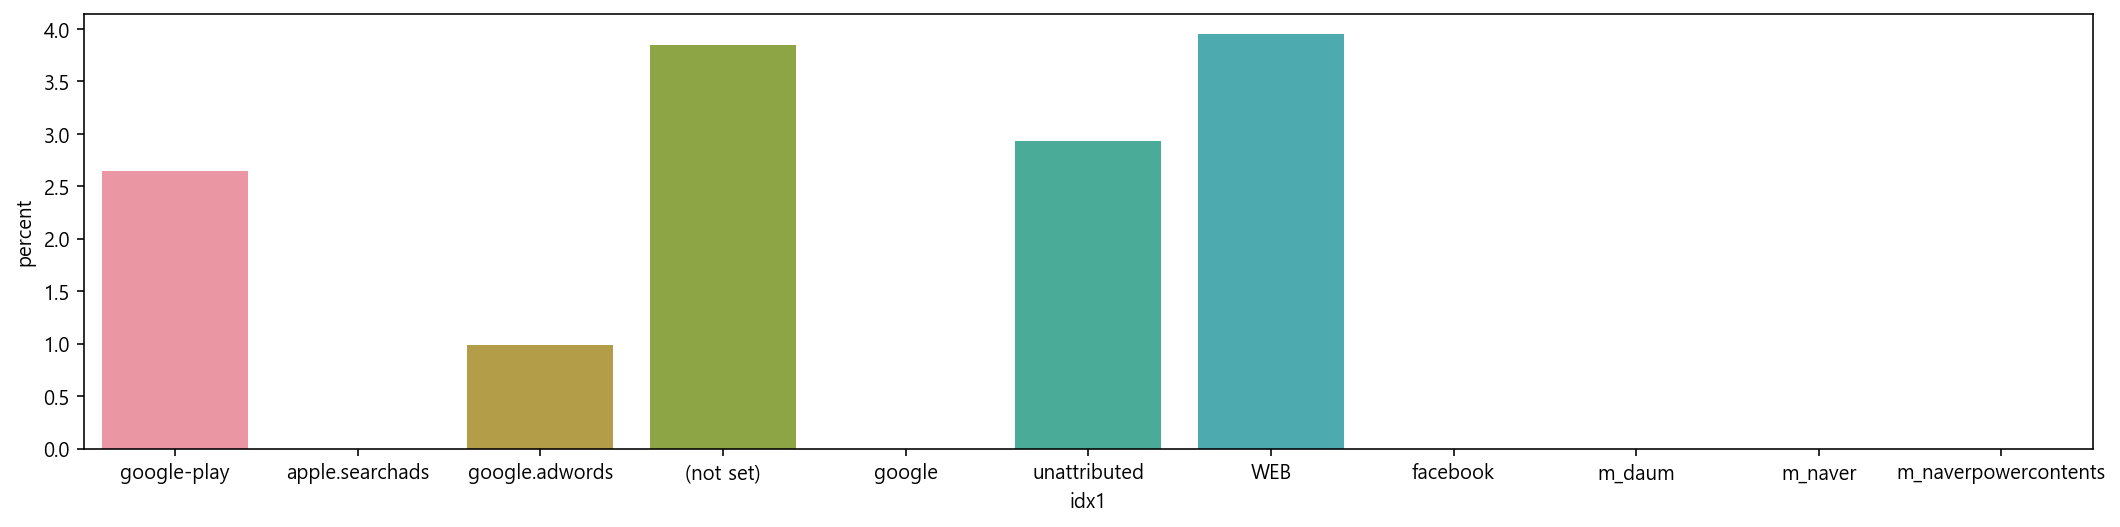

,idx0,idx1,total,signup,percent
0,app-market,google-play,227.0,6.0,2.643172
1,paid,apple.searchads,4.0,0.0,0.000000
2,paid,google.adwords,303.0,3.0,0.990099
3,stranger,(not set),26.0,1.0,3.846154
4,stranger,google,55.0,0.0,0.000000
5,unattributed,unattributed,580.0,17.0,2.931034
6,viral,WEB,228.0,9.0,3.947368
7,viral,facebook,5.0,0.0,0.000000
8,viral,m_daum,9.0,0.0,0.000000
9,viral,m_naver,23.0,0.0,0.000000


In [20]:
### 1-1 1.에 이어 이들이 크몽에 처음 들어오게 된 경로는? 그리고 가입한 확률은?
new_signup(free_df)

In [21]:
## 2. 1결과에 이어 구매까지 걸린 시간
decide_buy(free_df)

05B38D4A-F228-46F4-9837-571E452DBCE1   00:23:18
7ad59ae6-83cb-4582-9a98-a63b04c779d7   00:03:14
8efd7a3c-b748-4e72-9b9e-204502c0dc4a   04:01:16
C3D95171-CD13-4DD9-8DD1-51A4C59C24E5   00:03:20
Name: decide_time, dtype: timedelta64[ns]

In [22]:
## 3. 2결과와 연결하여 어떤 상품을 구매했는지.
what_buy_newcustomer(free_df)

,userid,eventdatetime,channel,category1,category2,category3
90651,C3D95171-CD13-4DD9-8DD1-51A4C59C24E5,2018-09-28 03:50:41,unattributed,상담·컨설팅,운세,NaN
106044,8efd7a3c-b748-4e72-9b9e-204502c0dc4a,2018-09-28 04:40:34,WEB,마케팅,카페·블로그,포스팅
269730,05B38D4A-F228-46F4-9837-571E452DBCE1,2018-09-28 15:20:22,unattributed,상담·컨설팅,운세,NaN
433286,7ad59ae6-83cb-4582-9a98-a63b04c779d7,2018-09-29 14:51:59,unattributed,상담·컨설팅,운세,NaN


In [23]:
## 4. 3결과와 연결하여 첫설치,가입,구매를 한사람이 처음 들어온 경로
first_buyer_from(free_df)

37542     unattributed
88893     unattributed
266152    unattributed
432336    unattributed
Name: channel, dtype: object

### 과제 제출

과제를 모두 푼 분들은 datascience@dsschool.co.kr 에 결과를 제출해주세요. 제출할 때는 다음의 자료가 필요합니다.

1. 과제를 푼 쥬피터 노트북. ipynb 파일로 보내주시면 됩니다.
1. 과제를 푼 지원자의 이력을 알 수 있는 이력서와 포트폴리오, 기타 본인의 커리어와 능력을 어필할 수 있는 자료.

과제에 대해 궁금한 점이 있다면 datascience@dsschool.co.kr로 문의 메일을 보내주세요. 다만 면접용 과제이니만큼 과제 풀이에 대한 힌트를 드릴 수는 없으며, 동일한 이유로 과제에 대한 솔루션을 제공해드릴 수 없는 점 양해 부탁드립니다. (컬럼이나 데이터, 그리고 문제에 대한 부연설명 요청 등은 언제든지 환영합니다)

수업 내용, 과제에 대한 문의사항은 datascience@dsschool.co.kr로, 수료증이나 기수 변경, 기타 영수증 발급은 support@dsschool.co.kr 로 보내주세요.